In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.

session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

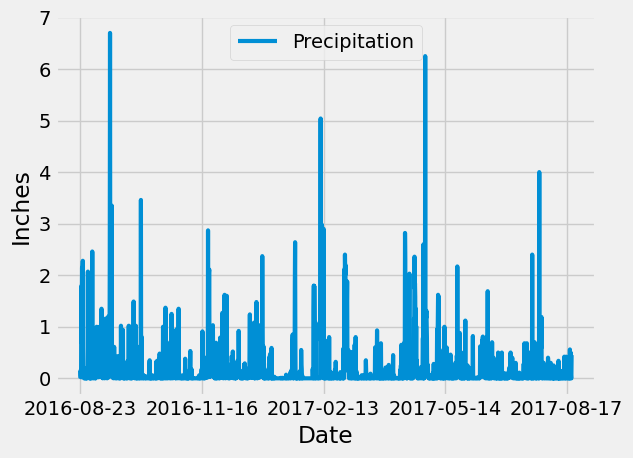

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date_result = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date_result[0], "%Y-%m-%d").date()
latest_date 

# Calculate the date one year from the last date in data set.
year_ago = latest_date - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores

scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date <= latest_date).\
    filter(measurement.date >= year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data_df = pd.DataFrame(scores, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_data_df = precipitation_data_df.sort_values(by='Date')
precipitation_data_df = precipitation_data_df.dropna()
precipitation_data_df

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_data_df.set_index('Date', inplace=True)
precipitation_data_df
ax = precipitation_data_df.plot(legend=True, linewidth=3, grid=True)
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Inches')

#Set the x-axis tick positions and labels
nbins = 5
ax.xaxis.set_major_locator(MaxNLocator(nbins=nbins))

# Set y-axis limits
#plt.ylim(0, 7)


plt.show()

In [26]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_summary = precipitation_data_df['Precipitation'].describe()
print(prcp_summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset
total = session.query(func.count(station.id)).all()
total

[(9,)]

In [32]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    station.station,  
    func.count(measurement.id).label('count')  
).join(measurement, station.station == measurement.station).group_by(station.station).order_by(func.count(measurement.id).desc()).all() 

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_data = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == most_active_station_id).all()

temperature_data

[(54.0, 85.0, 71.66378066378067)]

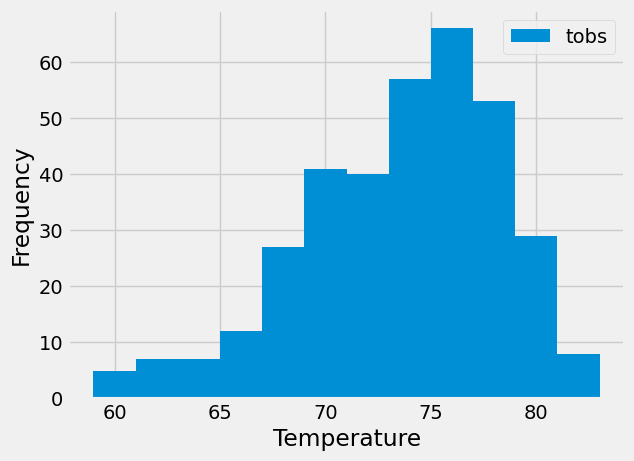

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data_p12m = session.query(
    measurement.tobs
).filter(measurement.station == most_active_station_id,measurement.date >= year_ago).all()

temperature_data_df = pd.DataFrame(temperature_data_p12m, columns=['Temperature'])

plt.hist(temperature_data_df['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

# Close Session

In [52]:
# Close Session
session.close()